In [1]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2022-11-05 08:41:01--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.85.5.10, 2a02:26f0:fe00:4ac::317f, 2a02:26f0:fe00:48e::317f
Connecting to download.microsoft.com (download.microsoft.com)|104.85.5.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   180MB/s    in 4.3s    

2022-11-05 08:41:05 (184 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [24]:
!unzip kagglecatsanddogs_5340.zip

Archive:  kagglecatsanddogs_5340.zip
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#matplotlib.use('Agg')
import warnings
import os
import cv2
import PIL
import tqdm
import random
import tensorflow as tf

from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
warnings.filterwarnings('ignore')

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Nov  5 08:43:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Dog':
            label.append(1)
        else:
            label.append(0)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages/Cat/890.jpg 0


In [54]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,PetImages/Cat/4799.jpg,0
1,PetImages/Dog/7192.jpg,1
2,PetImages/Dog/881.jpg,1
3,PetImages/Dog/3080.jpg,1
4,PetImages/Dog/3984.jpg,1


In [55]:
print(df[df['label']==1])

                        images  label
1       PetImages/Dog/7192.jpg      1
2        PetImages/Dog/881.jpg      1
3       PetImages/Dog/3080.jpg      1
4       PetImages/Dog/3984.jpg      1
7        PetImages/Dog/197.jpg      1
...                        ...    ...
24990  PetImages/Dog/10218.jpg      1
24991   PetImages/Dog/2451.jpg      1
24993   PetImages/Dog/1767.jpg      1
24994   PetImages/Dog/1957.jpg      1
24999   PetImages/Dog/5215.jpg      1

[12501 rows x 2 columns]


In [9]:
error_list = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        error_list.append(image)
print(error_list)

['PetImages/Cat/Thumbs.db', 'PetImages/Cat/666.jpg', 'PetImages/Dog/Thumbs.db', 'PetImages/Dog/11702.jpg']


In [66]:
# delete error files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
print(len(df))

24998


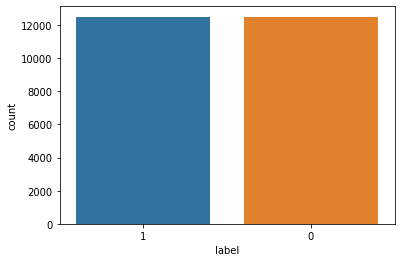

In [12]:
# plot the balanced data
# 12499 image of each class
sns.countplot(df['label'])

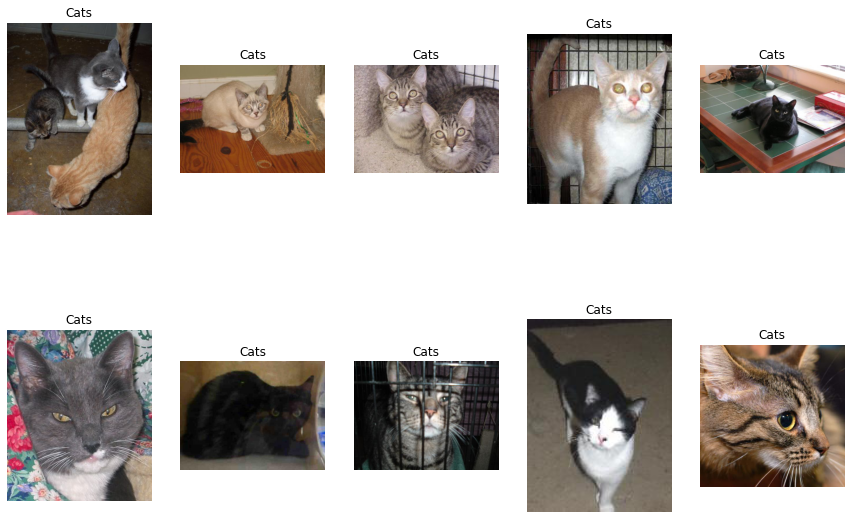

In [63]:
plt.figure(figsize=(15,10))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+10]

for index, file in enumerate(files):
    plt.subplot(2,5, index+1)
    img = load_img(file)
    img = np.array(img) 
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

In [64]:
# convert to str to use in model.fit
df['label'] = df['label'].astype('str')
df.head()

,images,label
0,PetImages/Cat/4799.jpg,0
1,PetImages/Dog/7192.jpg,1
2,PetImages/Dog/881.jpg,1
3,PetImages/Dog/3080.jpg,1
4,PetImages/Dog/3984.jpg,1


In [67]:
train_data, test_data = train_test_split(df, test_size=0.2,random_state=1)
print(len(train_data),len(test_data))

19998 5000


In [68]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 40,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')
val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(train_data,
                                                       x_col = 'images',
                                                       y_col = 'label',
                                                       target_size = (128,128),
                                                       batch_size = 512,
                                                       class_mode = 'binary')
val_itarator = val_generator.flow_from_dataframe(test_data,
                                                  x_col = 'images',
                                                  y_col = 'label',
                                                  target_size = (128,128),
                                                  batch_size = 512,
                                                  class_mode = 'binary')
 

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [69]:
model = Sequential()

model.add(Conv2D(16,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [73]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.save_weights(checkpoint_path.format(epoch=0))

In [74]:
H = model.fit(train_iterator,epochs=30,validation_data=val_itarator,callbacks=[cp_callback])

Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 0.7470 - accuracy: 0.5288
Epoch 1: saving model to training_1/cp.ckpt
40/40 [==============================] - 138s 3s/step - loss: 0.7470 - accuracy: 0.5288 - val_loss: 0.6558 - val_accuracy: 0.6018
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 0.6408 - accuracy: 0.6226
Epoch 2: saving model to training_1/cp.ckpt
40/40 [==============================] - 131s 3s/step - loss: 0.6408 - accuracy: 0.6226 - val_loss: 0.5945 - val_accuracy: 0.6788
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: 0.5974 - accuracy: 0.6808
Epoch 3: saving model to training_1/cp.ckpt
40/40 [==============================] - 133s 3s/step - loss: 0.5974 - accuracy: 0.6808 - val_loss: 0.5593 - val_accuracy: 0.7124
Epoch 4/30
40/40 [==============================] - ETA: 0s - loss: 0.5685 - accuracy: 0.7033
Epoch 4: saving model to training_1/cp.ckpt
40/40 [==============================] - 130s 3s/step - lo

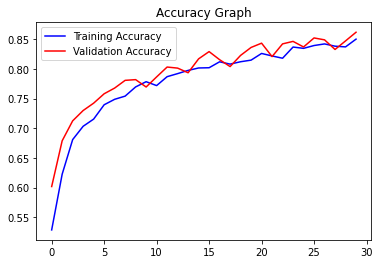

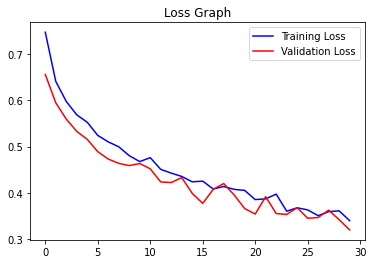

In [75]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = H.history['loss']
val_loss = H.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
#plt.show()

In [78]:
from google.colab import drive
drive.mount('/content/drive')
# Insert the directory

FOLDERNAME = 'CV'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(128, 128, 3)
1/1 [==============================] - 0s 17ms/step
(128, 128, 3)
1/1 [==============================] - 0s 23ms/step
(128, 128, 3)
1/1 [==============================] - 0s 18ms/step
(128, 128, 3)
1/1 [==============================] - 0s 15ms/step
(128, 128, 3)
1/1 [==============================] - 0s 16ms/step
(128, 128, 3)
1/1 [==============================] - 0s 15ms/step
(128, 128, 3)
1/1 [==============================] - 0s 16ms/step
(128, 128, 3)
1/1 [==============================] - 0s 22ms/step
(128, 128, 3)
1/1 [==============================] - 0s 16ms/step


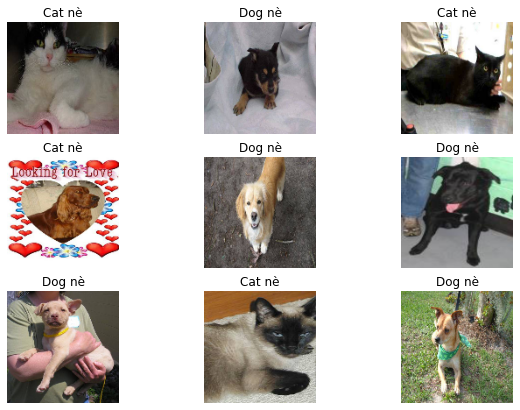

In [104]:
IMAGE_SIZE = 128
import glob
# Preprocess an image

images_paths = glob.glob("/content/drive/MyDrive/CV/test1/*.jpg")

start = random.randint(0, len(images_paths))
rows = 3
plt.figure(figsize=(10,7))
img_paths = images_paths[start:start+9]
for num, x in enumerate(img_paths):
    image = load_img(x)
    image = cv2.resize(np.array(image),(128,128))

    #image = np.expand_dims(image, axis=-1) # To make the shape as (1, 2566, 256, 1)
    image_pre = np.expand_dims(image, axis=0) # To make the shape as (1, 2566, 256, 1)
    print(image.shape)
    pred = model.predict(image_pre)
    if pred[0] > 0.5: class_name = 'Dog nè'
    else: class_name = 'Cat nè'
    plt.subplot(rows,3, num+1)
    plt.title(class_name)
    plt.axis('off')
    plt.imshow(image)
#plt.show()
